In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import shap

We use continuous and categorical data from the **[IBM Base Samples](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2018/09/12/base-samples-for-ibm-cognos-analytics)** to predict whether or not a customer will stop using a company's service. In business lingo, this is called Customer Churn.

In [11]:
df = pd.read_csv(r'/Users/theoeudes/Desktop/Data Science/Telco_customer_churn.csv')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


The last four variables contain exit interview information and should not be used for prediction, so we will remove them.

In [12]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'],
        axis=1, inplace=True)
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [13]:
df['Count'].unique() , df['Country'].unique() , df['State'].unique()

(array([1]),
 array(['United States'], dtype=object),
 array(['California'], dtype=object))

So we can omit those variables. In contrast, City contains a bunch of different city names, so we will leave it in.

In [14]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

We will also remove `Customer ID` because it is different for every customer and useless for classification. Lastly, we will drop `Lat Long` because there are separate columns for `Latitude` and `Longitude`.

In [15]:
df.drop(['CustomerID', 'Count', 'Country', 'State', 'Lat Long'],
        axis=1, inplace=True) 
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


**NOTE:** Although it is OK to have whitespace in the city names in **City** for **XGBoost** and classification, we can't have any whitespace if we want to draw a tree. So let's take care of that now by replacing the white space in the city names with an underscore character `_`.

**ALSO NOTE** We can easily remove whitespaces from all values, not just city names, but we will wait to do that until after we have identified missing values.

In [16]:
df['City'].replace(' ', '_', regex=True, inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [17]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

We also need to eliminate the whitespace in the column names, so we'll replace it with underscores. 

In [18]:
df.columns = df.columns.str.replace(' ', '_')
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


We have removed all of the data that will not help use create an XGBoost model and reformatted the column names and city names so that we can draw a tree. It's time to deal with missing Data

# Missing Data Part 1: Identifying Missing Data

XGBoost has default behavior for missing data, we have to do is identify missing values and make sure they are set to `0`

In [19]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [20]:
print(df.apply(lambda col: col.unique()))

City                 [Los_Angeles, Beverly_Hills, Huntington_Park, ...
Zip_Code             [90003, 90005, 90006, 90010, 90015, 90020, 900...
Latitude             [33.964131, 34.059281, 34.048013, 34.062125, 3...
Longitude            [-118.272783, -118.30742, -118.293953, -118.31...
Gender                                                  [Male, Female]
Senior_Citizen                                               [No, Yes]
Partner                                                      [No, Yes]
Dependents                                                   [No, Yes]
Tenure_Months        [2, 8, 28, 49, 10, 1, 47, 17, 5, 34, 11, 15, 1...
Phone_Service                                                [Yes, No]
Multiple_Lines                             [No, Yes, No phone service]
Internet_Service                                [DSL, Fiber optic, No]
Online_Security                         [Yes, No, No internet service]
Online_Backup                           [Yes, No, No internet service]
Device

Two columns can cause troubles for us, Monthly/Total_Charges

In [21]:
df['Monthly_Charges'] = pd.to_numeric(df['Monthly_Charges'])
#df['Total_Charges'] = pd.to_numeric(df['Total_Charges']) #Return ValueError: Unable to parse string " " at position 2234

There are blank spaces, `" "`, in the Total_Charges column. So we need to deal with those.

In [22]:
len(df.loc[df['Total_Charges'] == ' '])

11

In [23]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


We see that all **11** people with `Total_Charges == ' '` have just signed up, because **Tenure_Months** is `0`. These people also all have **Churn_Value** set to `0` because they just signed up. So we have a few choices here, we can set **Total_Charges** to `0` for these **11** people or we can remove them. We will try setting **Total_Charges** to `0`.

In [24]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0

In [25]:
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


We modified **Total Charges** correctly by looking at everyone who had **Tenure Months** set to `0`.

In [26]:
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


**Total_Charges** still has the `object` data type. That is not good because **XGBoost** only allows `int`, `float` or `boolean` data types. We can fix this by converting it with `to_numeric()`.

In [27]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

Now we can replace all of the other whitespaces in all of the columns with underscores (so we can draw a picture of the one of the XGBoost trees if we want).

In [28]:
df.replace(' ', '_', regex=True, inplace=True)
df.head(), df.size

(          City  Zip_Code   Latitude   Longitude  Gender Senior_Citizen  \
 0  Los_Angeles     90003  33.964131 -118.272783    Male             No   
 1  Los_Angeles     90005  34.059281 -118.307420  Female             No   
 2  Los_Angeles     90006  34.048013 -118.293953  Female             No   
 3  Los_Angeles     90010  34.062125 -118.315709  Female             No   
 4  Los_Angeles     90015  34.039224 -118.266293    Male             No   
 
   Partner Dependents  Tenure_Months Phone_Service  ... Device_Protection  \
 0      No         No              2           Yes  ...                No   
 1      No        Yes              2           Yes  ...                No   
 2      No        Yes              8           Yes  ...               Yes   
 3     Yes        Yes             28           Yes  ...               Yes   
 4      No        Yes             49           Yes  ...               Yes   
 
   Tech_Support Streaming_TV Streaming_Movies        Contract  \
 0           No    

# Split the Data into Dependent and Independent Variables

In [29]:
X = df.drop('Churn_Value', axis=1).copy()
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [30]:
y = df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

# One-Hot Encoding

 The list below tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **City** - **Category**
  - Los Angeles, Beverly Hills, etc.
- **Zip Code** - **Category**
  - 90003, 90005, etc.
- **Latitude** - **Float**
- **Longitude** - **Float**
- **Gender** - **Category**
  - Female, Male
- **Senior Citizen** - **Category**
  - Yes, No
- **Partner** - **Category**
  - Yes, No
- **Dependents** - **Category**
  - Yes, No
- **Tenure Months** - **Float**
- **Phone Service** - **Category**
  - Yes, No
- **Multiple Lines** - **Category**
  - Yes, No
- **Internet Service** - **Category**
  - No, DSL, Fiber optic
- **Online Security** - **Category**
  - Yes, No
- **Online Backup** - **Category**
  - Yes, No
- **Device Protection** - **Category**
  - Yes, No
- **Tech Support** - **Category**
  - Yes, No
- **Streaming TV** - **Category**
  - Yes, No
- **Streaming Movies** - **Category**
  - Yes, No
- **Contract** - **Category**
  - Month-to-month, One year, Two year
- **Paperless Billing** - **Category**
  - Yes, No
- **Payment Method** - **Category**
  - Mailed check, Electronic check, etc...
- **Monthly Charges** - **Float**
- **Total Charges** - **Float**


let's look at the data types in `X` to remember how python is seeing the data right now.

In [31]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

**Latitude**, **Longitude**, **Monthly_Charges** and **Total_Charges** are all `float64`, we want them to be floating point numbers so it's good. However, all of the columns that are `object` typeneed to be inspected to make sure they only contain reasonable values. Because, while XGBoost natively supports continuous data, like **Monthly_Charges** and **Total_Charges**, it does not natively support categorical data, like **Phone_Service**, which contains 2 different categories. In order to use categorical data with XGBoost.

In [32]:
X_encoded = pd.get_dummies(X, columns=['City', 
                                       'Gender', 
                                       'Senior_Citizen', 
                                       'Partner',
                                       'Dependents',
                                       'Phone_Service',
                                       'Multiple_Lines',
                                       'Internet_Service',
                                       'Online_Security',
                                       'Online_Backup',
                                       'Device_Protection',
                                       'Tech_Support',
                                       'Streaming_TV',
                                       'Streaming_Movies',
                                       'Contract',
                                       'Paperless_Billing',
                                       'Payment_Method'])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


Let's verify that `y` only contains **1s** and **0s** 

In [33]:
y.unique()

array([1, 0])

We have to check one more thing before digging into the model itself: The balance of the data

In [34]:
(sum(y)/len(y))*100

26.536987079369588

only **27%** of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both the **training** set and the **testing** set.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [36]:
sum(y_train)/len(y_train)

0.2654297614539947

In [37]:
sum(y_test)/len(y_test)

0.26519023282226006

# Preliminary XGBoost Model

we will use **early stopping** to stop building trees when they no longer improve the situation.

In [38]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric="logloss",
                            seed=42, 
                            use_label_encoder=False)

clf_xgb.fit(X_train, 
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64404
[2]	validation_0-aucpr:0.65124
[3]	validation_0-aucpr:0.65051
[4]	validation_0-aucpr:0.65321
[5]	validation_0-aucpr:0.64854
[6]	validation_0-aucpr:0.65459
[7]	validation_0-aucpr:0.65895
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65850
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66527
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66000
[15]	validation_0-aucpr:0.66027
[16]	validation_0-aucpr:0.65781
[17]	validation_0-aucpr:0.65593
[18]	validation_0-aucpr:0.65738
[19]	validation_0-aucpr:0.65829
[20]	validation_0-aucpr:0.65683
[21]	validation_0-aucpr:0.65707


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Let's see how it performs on the testing Dataset by running the testing Dataset down the model and drawing a Confusion Matrix.

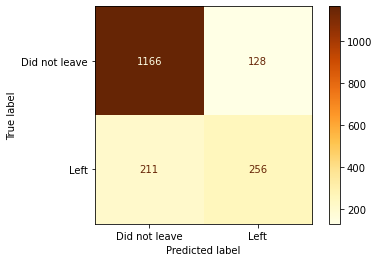

In [39]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      cmap=plt.cm.YlOrBr,
                      display_labels=["Did not leave", "Left"])

We see that of the **1294** people that **did not leave**, **1166 (90%)** were correctly classified. And of the **467** people that **left the company**, **256 (54%)** were correctly classified. The XGBoost model was not really great. Part of the problem is that our data is imbalanced, which we saw earlier and we see this in the confusion matrix with the top row showing **1262** people that did not default and the bottom row showing **467** people who did. Because people leaving costs the company a lot of money, we would like to capture more of the people that left. 

XGBoost has a parameter, `scale_pos_weight`, that helps with imbalanced data. So let's try to improve predictions using Cross Validation to optimize the parameters.

# Optimize Parameters using Cross Validation and GridSearch()

In [40]:
# I ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
# in order to optimize parameters in a short period of time.

param_grid = {
    
    'max_depth': [4],
     'learning_rate': [0.1, 0.5, 1],
     'gamma': [0.25],
     'reg_lambda': [10.0, 20, 100],
      'scale_pos_weight': [3]

}


# To speed up cross validiation, and to further prevent overfitting.
# We are only using a random subset of the data (90%) and are only
# using a random subset of the features (columns) (50%) per tree.
 
optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                 eval_metric="logloss",
                                 seed=42,
                                 subsample=0.9,
                                 colsample_bytree=0.5,
                                 use_label_encoder=False),
                                 param_grid=param_grid,
                                 scoring='roc_auc',
                                 verbose=1, 
                                 n_jobs = 10,
                                 cv = 3
                                 )

optimal_params.fit(X_train, 
                    y_train, 
                    early_stopping_rounds=10,                
                    eval_metric='auc',
                    eval_set=[(X_test, y_test)],
                    verbose=False)

print(optimal_params.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  27 | elapsed:  1.2min finished


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 3}


Corresponding to the Cross-Validation results, we should set `gamma=0.25`, `learn_rate=0.1`, `max_depth=4`, and `reg_lambda=10`

# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

In [41]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        eval_metric="logloss",
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=4,
                        reg_lambda=10,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        use_label_encoder=False)
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.55001
[1]	validation_0-aucpr:0.56932
[2]	validation_0-aucpr:0.60830
[3]	validation_0-aucpr:0.61361
[4]	validation_0-aucpr:0.61895
[5]	validation_0-aucpr:0.62025
[6]	validation_0-aucpr:0.62607
[7]	validation_0-aucpr:0.62667
[8]	validation_0-aucpr:0.63455
[9]	validation_0-aucpr:0.63476
[10]	validation_0-aucpr:0.63491
[11]	validation_0-aucpr:0.63240
[12]	validation_0-aucpr:0.63346
[13]	validation_0-aucpr:0.63336
[14]	validation_0-aucpr:0.63233
[15]	validation_0-aucpr:0.63323
[16]	validation_0-aucpr:0.63119
[17]	validation_0-aucpr:0.63158
[18]	validation_0-aucpr:0.63909
[19]	validation_0-aucpr:0.63952
[20]	validation_0-aucpr:0.65137
[21]	validation_0-aucpr:0.65583
[22]	validation_0-aucpr:0.65661
[23]	validation_0-aucpr:0.65585
[24]	validation_0-aucpr:0.65636
[25]	validation_0-aucpr:0.65873
[26]	validation_0-aucpr:0.65922
[27]	validation_0-aucpr:0.65938
[28]	validation_0-aucpr:0.66044
[29]	validation_0-aucpr:0.66150
[30]	validation_0-aucpr:0.66144
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0.25, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

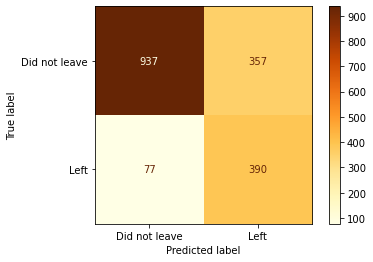

In [42]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      cmap=plt.cm.YlOrBr,
                      display_labels=["Did not leave", "Left"])

The optimized XGBoost model is a lot better at identifying people that left the company. Of the **467** people that left the company, **390 (84%)**, were correctly identified. Before optimization, we only correctly identified **256 (54%)**. However, this improvement was at the expense of not being able to correctly classify as many people that did not leave. Before optimization, we correctly identified **1,166 (90%)** people that did not leave. Now we only correctly classify **937 (72%)**. It's all about trade-off between recall and precision, but this trade off **may be better for the company** because now it can focus resources on the people that leave if that will help them retain them.

In [43]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        eval_metric="logloss", 
                        objective='binary:logistic',
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=4,
                        reg_lambda=10,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        n_estimators=1,
                        use_label_encoder=False) 

clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0.25, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

## Extra : Shap of the model

In [44]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        eval_metric="logloss",
                        gamma=0.25,
                        learning_rate=0.1,
                        max_depth=4,
                        reg_lambda=10,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        use_label_encoder=False)
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.55001
[1]	validation_0-aucpr:0.56932
[2]	validation_0-aucpr:0.60830
[3]	validation_0-aucpr:0.61361
[4]	validation_0-aucpr:0.61895
[5]	validation_0-aucpr:0.62025
[6]	validation_0-aucpr:0.62607
[7]	validation_0-aucpr:0.62667
[8]	validation_0-aucpr:0.63455
[9]	validation_0-aucpr:0.63476
[10]	validation_0-aucpr:0.63491
[11]	validation_0-aucpr:0.63240
[12]	validation_0-aucpr:0.63346
[13]	validation_0-aucpr:0.63336
[14]	validation_0-aucpr:0.63233
[15]	validation_0-aucpr:0.63323
[16]	validation_0-aucpr:0.63119
[17]	validation_0-aucpr:0.63158
[18]	validation_0-aucpr:0.63909
[19]	validation_0-aucpr:0.63952
[20]	validation_0-aucpr:0.65137
[21]	validation_0-aucpr:0.65583
[22]	validation_0-aucpr:0.65661
[23]	validation_0-aucpr:0.65585
[24]	validation_0-aucpr:0.65636
[25]	validation_0-aucpr:0.65873
[26]	validation_0-aucpr:0.65922
[27]	validation_0-aucpr:0.65938
[28]	validation_0-aucpr:0.66044
[29]	validation_0-aucpr:0.66150
[30]	validation_0-aucpr:0.66144
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0.25, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

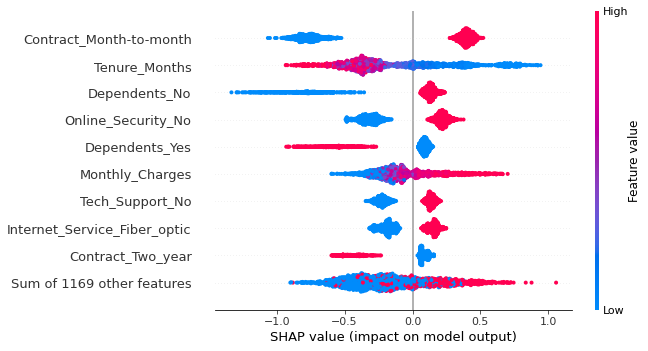

In [45]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

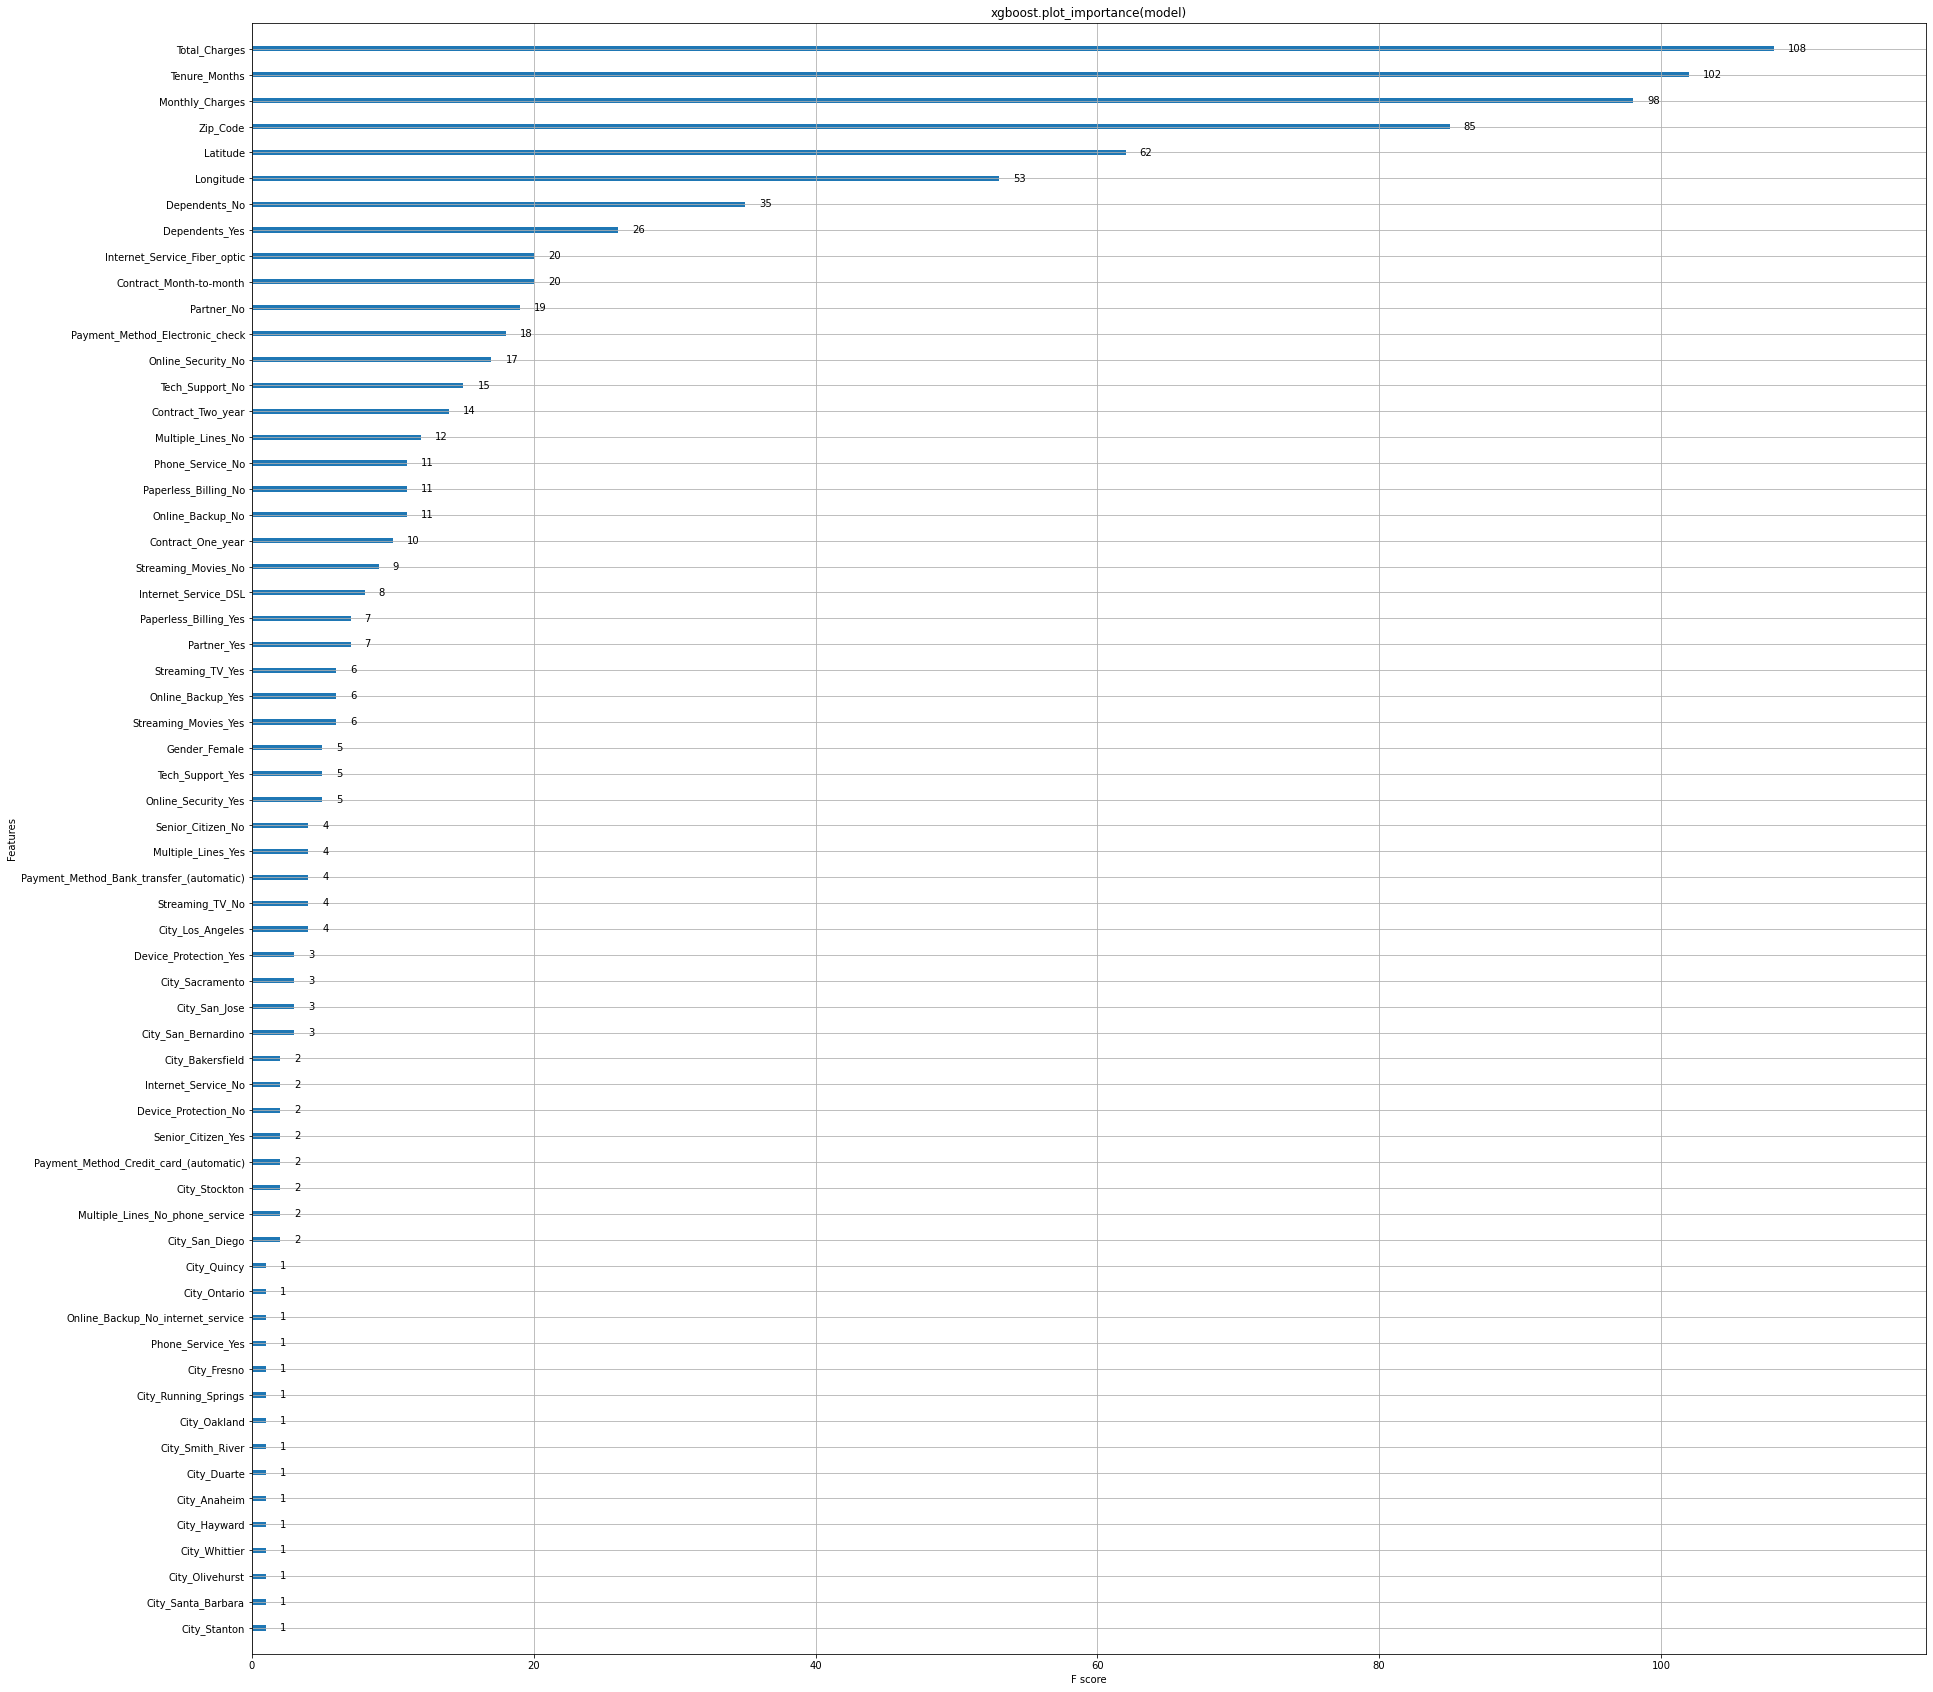

In [47]:
xgb.plot_importance(clf_xgb)
plt.rcParams["figure.figsize"]=(30, 30)
plt.title("xgboost.plot_importance(model)")
plt.show()